## Problem 3 - Psychopathy

You are interested in causes and treatment options for Psychopathy. You obtained a dataset, contained in the file psychopathy.mat obtained from a prison for violent offenders in upstate New York (not everyone in the prison is a psychopath, but they are
more prevalent than in the general population). Each row represents data from one prisoner. All study participants underwent a structural scan with a mobile, truck-mounted MRI. The fiorst data column contains the estimated cortical volume of paralimbic areas, relative to the population median, in cm3. The second column contains the Hare Psychopathy Checklist (PCL-R) scores, which range from 0 to 40 (the higher the score, the more psychopathic traits someone exhibits). These scores are not distributed normally in the general population(median = 4) and definitely not normal in this subpopulation (median = 20). The third column indicates whether they already participated in an experimental treatment program known as ^adecompression therapy^a (0 = did not yet participate, 1 = did already participate). To avoid self-selection effects, everyone in this dataset agreed to the therapy, but prisoner swere randomly assigned to an earlier and a later treatment group, so that the untreated prisoners could serve as a control group.

In [2]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
import math
import random 
#Load given data 
load_data = loadmat('psychopathy.mat')
cortical_vol = load_data['DATA'][:,0]
PLCr_scores= load_data['DATA'][:,1]
participation= load_data['DATA'][:,2]
print('loaded the psycopathy data')

loaded the psycopathy data


You want to model PCL-R scores as a function of relative volume of paralimbic areas. Use polynomial regression to find a model that best explains the data using cross-validation. What degree does it have?

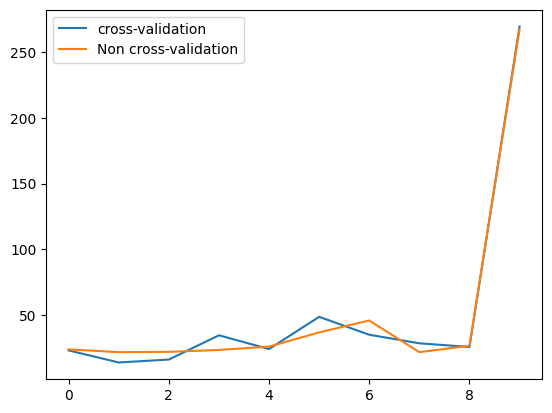

In [8]:
RMSE_allCV = []
RMSE_all = []
for i in range(10):
    # Split data for cross validation (cv)
    cv_index = random.randint(0,len(PLCr_scores)-1)
    scores_test = PLCr_scores[cv_index]
    scores_train = np.delete(PLCr_scores, [cv_index], axis=0)
    vol_test = cortical_vol[cv_index]
    vol_train = np.delete(PLCr_scores, [cv_index], axis=0)
    # Polynomial fit of cv data and non-cv data 
    # non-cv data
    coeffs = np.polyfit(PLCr_scores,cortical_vol,deg = i) # train
    poly_pred = np.poly1d(coeffs)(cortical_vol) # test
    RMSE = math.sqrt(np.square(np.subtract(PLCr_scores,poly_pred)).mean()) # evaluate
    # cv data 
    cv_coeffs = np.polyfit(scores_train,vol_train,deg = i) # train 
    cv_poly_pred = np.poly1d(cv_coeffs)(vol_test) # test
    cv_RMSE = math.sqrt(np.square(np.subtract(scores_test,poly_pred)).mean()) # evaluate
    # append data
    RMSE_all.append(RMSE)
    RMSE_allCV.append(cv_RMSE)

fig,ax = plt.subplots()
ax.plot(np.arange(0,10,1),RMSE_allCV,label= 'cross-validation')
ax.plot(np.arange(0,10,1),RMSE_all,label= 'Non cross-validation')
plt.legend()

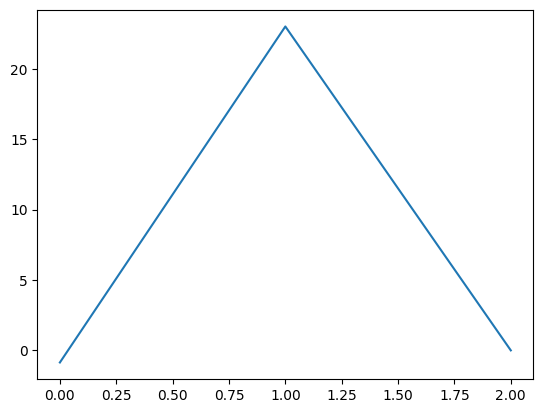

In [10]:
p = [1,2.3]
p.pop

In [11]:
coeffs = np.polyfit(PLCr_scores,cortical_vol,deg=3)
p = np.poly1d(coeffs)
p([1,2,3])

c:\Users\Juan Pablo Botero T\.conda\envs\uv-vis\lib\site-packages\IPython\core\interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


array([-0.19236441, -0.33686142, -0.42823191])